# HD 155358
Two reasons to revisit -  
1) The original analysis didn't account for any mutual perturbations. If the planets are indeed in resonance, then resonant terms will be very dominant, and mutual perturbations can affect the dynamics, even on short timescales. The difference between a linear model and the N-body model could provide some insight into whether the system is in resonance!  
2) They performed 100,000 simulations assessing the longterm stability of the system. Can Machine Learning do as good a job with many fewer systems (e.g. 5,000)?

Plan:  
i) Simultaneously input to emcee i) WHFAST to generate radial velocity curves, ii) Gaussian process to model the stellar jitter (via George). Fit these to the available RV observations to get orbital parameters.  
ii) Perform a stability analysis using machine learning to see if you can match the detailed stability analysis of Robertson et al. (2012) where they performed over 100,000 (!) simulations.  

CHROMOSPHERIC ACTIVITY AND JITTER MEASUREMENTS FOR 2630 STARS ON THE CALIFORNIA PLANET SEARCH - This paper by Isaacson and Fisher have stellar jitter parameters measured for HD 155358, maybe just use those, or at least compare your jitter parameters to those?

Compare the semi-major amplitude derived from N-body compared to the linear combination of separate values to see the difference - http://exoplanetarchive.ipac.caltech.edu/docs/poet_calculations.html

In [1]:
import pandas as pd
import numpy as np
import rebound
import emcee
import multiprocessing

import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("RV.txt", delimiter=' ')

In [3]:
#Don't want to move to COM, want to see relative to the background. 
def fit_RV(times,theta):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    v = np.empty(0)    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* a1**(1.5) / 50.    #dt = 50 steps per orb per of inner planet
    sim.add(m=m1sini*mJ/sini,a=a1,l=lambda1,h=h1,k=k1) 
    sim.add(m=m2sini*mJ/sini,a=a2,l=lambda2,h=h2,k=k2) 
    sim.move_to_com()
    for t in times*dtoyr2pi:
        sim.integrate(t)
        v = np.append(v,-AUyr2ms*sim.particles[0].vy*sini)
        #v = np.append(v,AUyr2ms*(sim.particles[0].vx*np.sin(phi) + sim.particles[0].vy*np.cos(phi))*sini) #coordinate transf from (x,y,z)->(x',y',z'), take y' component
    return v 

### Chicken Scratch

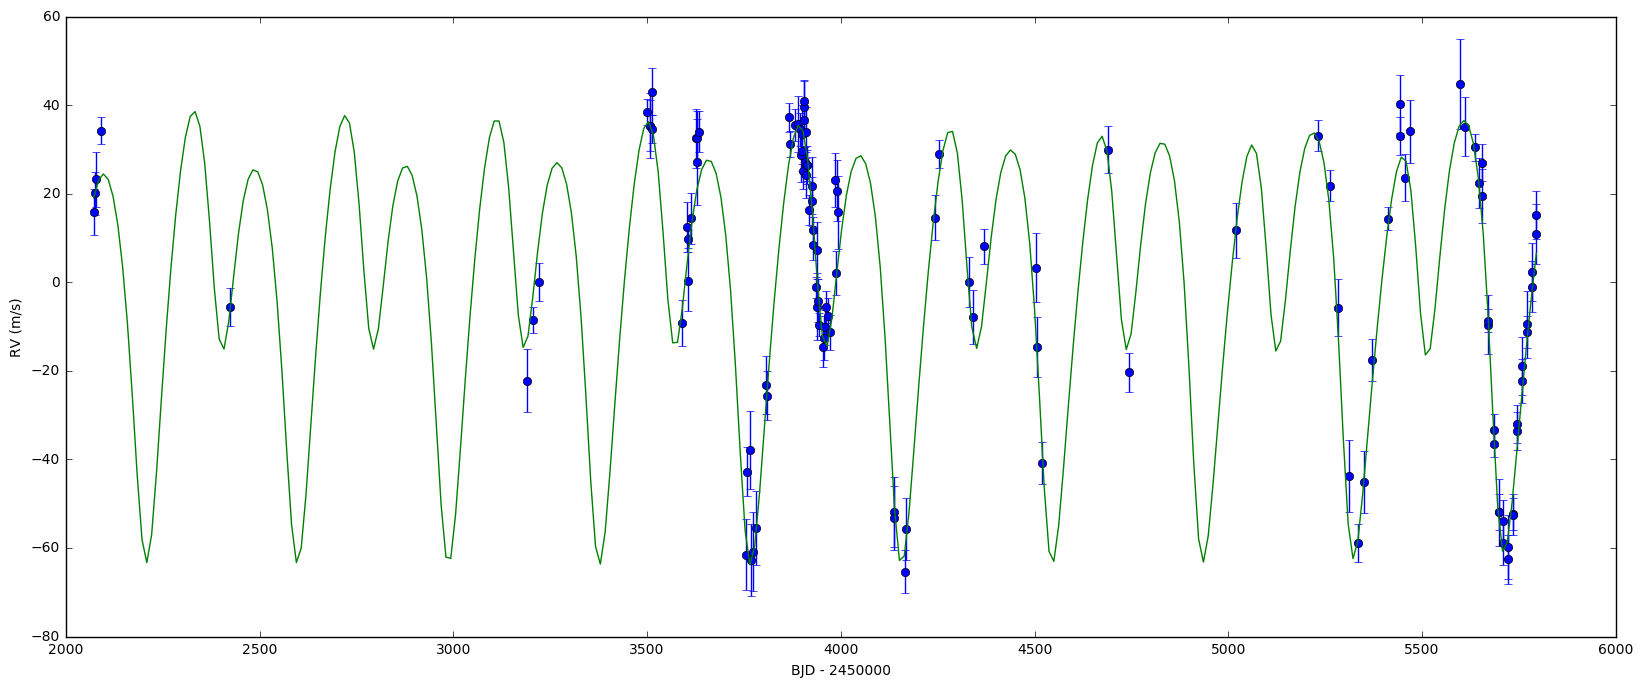

In [16]:
#conv
dtoR = np.pi/180.                          #degrees -> radians

#data
t0 = data["BJD"].iloc[0]
times = data["BJD"] - t0                    #in Barycentric Julian Date (days)
m1sini,m2sini = 0.92907598,0.84091726       #Jupiter masses, default 0.85,0.82
a1,a2 = 0.64141678,1.02299252               #AU, default: 0.64, 1.02
e1,e2 = 0.17145134,0.103073                 #default: 0.17,0.16
w1,w2 = 2.92629096,5.5671592                #in radians, default: 143, 180
M1,M2 = 2.03300709,1.86941606               #in degrees, default: 129, 233

#observer angles - I dont think I need phi, since that just shifts w
sini = 0.32679329                                   #inclination angle (sini = 0-1)

h1,h2 = 0.0366292356588, -0.067656280042    #e*sin(pomega)
k1,k2 = -0.167492868752, 0.0777603440057    #e*cos(pomega)
lambda1,lambda2 = M1+w1, M2+w2
tt = np.linspace(t0,max(data["BJD"]),300)
times = tt - t0

#fit
theta = m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini     #hk

plt.figure(figsize=(20,8))
plt.errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o')
plt.plot(tt,fit_RV(times,theta))
plt.xlabel("BJD - 2450000")
plt.ylabel("RV (m/s)")
#plt.savefig("fits/MAP_hkfit.png")

### emcee

In [75]:
def lnlike(theta_j, times, y, yerr2):
    theta, jitter2 = theta_j[:-1], theta_j[-1]
    model = fit_RV(times,theta)
    return -0.5*np.sum( (y - model)**2/(yerr2 + jitter2) + np.log(yerr2 + jitter2) )

def lnprior(theta_j):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,jitter2 = theta_j
    if 0.4<m1sini<2 and 0.4<m2sini<2 and 0.2<a1<0.8 and 0.8<a2<1.4 and 0<=h1**2 + k1**2<1. and 0<=h2**2 + k2**2<1. and 0.<=lambda1<=2*np.pi and 0.<=lambda2<=2*np.pi and 0.05<=sini<=1. and 0.<jitter2<50.:
        return 0   
    return -np.inf 

def lnprob(theta_j, times, y, yerr2):
    lnp = lnprior(theta_j)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta_j, times, y, yerr2)

#def lnprior(theta_j):
#    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,jitter2 = theta_j
#    h1_2, h2_2, k1_2, k2_2 = h1**2, h2**2, k1**2, k2**2
#    e1_2, e2_2 = h1_2 + k1_2, h2_2 + k2_2 
#    if 0.4<m1sini<2 and 0.4<m2sini<2 and 0.4<a1<0.8 and 0.8<a2<1.4 and 0<=e1_2<1. and 0<=e2_2<1. and 0<=h1_2/e1_2<1. and 0<=h2_2/e2_2<1. and 0<=k1_2/e1_2<1. and 0<=k2_2/e2_2<1. and 0.<=lambda1<=2*np.pi and 0.<=lambda2<=2*np.pi and 0.05<=sini<=1. and 0.<jitter2<50.:
#        return 0   
#    return -np.inf 

In [5]:
#initialize parameters
times = data["BJD"] - data["BJD"].iloc[0] #BJD (days)
m1sini,m2sini = 0.916,0.851               #Jupiter masses, default 0.85,0.82
a1,a2 = 0.643,1.017                       #AU, default: 0.64, 1.02
h1,h2 = 0.0366,-0.067                     
k1,k2 = -0.167,0.078                      
lambda1,lambda2 = 2.31,6.18               #in radians, default: 129, 233
sini = 0.9                                #inclination angle (0-1)
jitter2 = 10                              #stellar jitter term squared (m^2/s^2)

theta_ini = [m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,jitter2]

ndim, nwalkers, n_it = len(theta_ini), 50, 1500

Run the MCMC. **Warning**. This could take a while.

In [137]:
pos = [theta_ini + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, data["RV"].values, (data["Unc"].values)**2));
sampler.run_mcmc(pos, n_it);
np.save("hk_%dwalk_%dit.npy"%(nwalkers,n_it),sampler.chain)

# Load and analyze data

In [58]:
#Corner plot
burnin = 200
#filename="emcee_chains/ewfit_nojitter_50walk_1500step"
#filename="emcee_chains/ewfit_jitter_nopool_nwalk50_nit1500"
#filename="emcee_chains/ewfit_jitter_50walk_5000it"

filename="emcee_chains/hk_50walk_1500it"
#filename="emcee_chains/hksemi-active_200walk_3000it"
#filename="emcee_chains/hksemi-active_50walk_1500it"
samples = np.load(filename+".npy")[:, burnin:, :].reshape((-1, ndim))

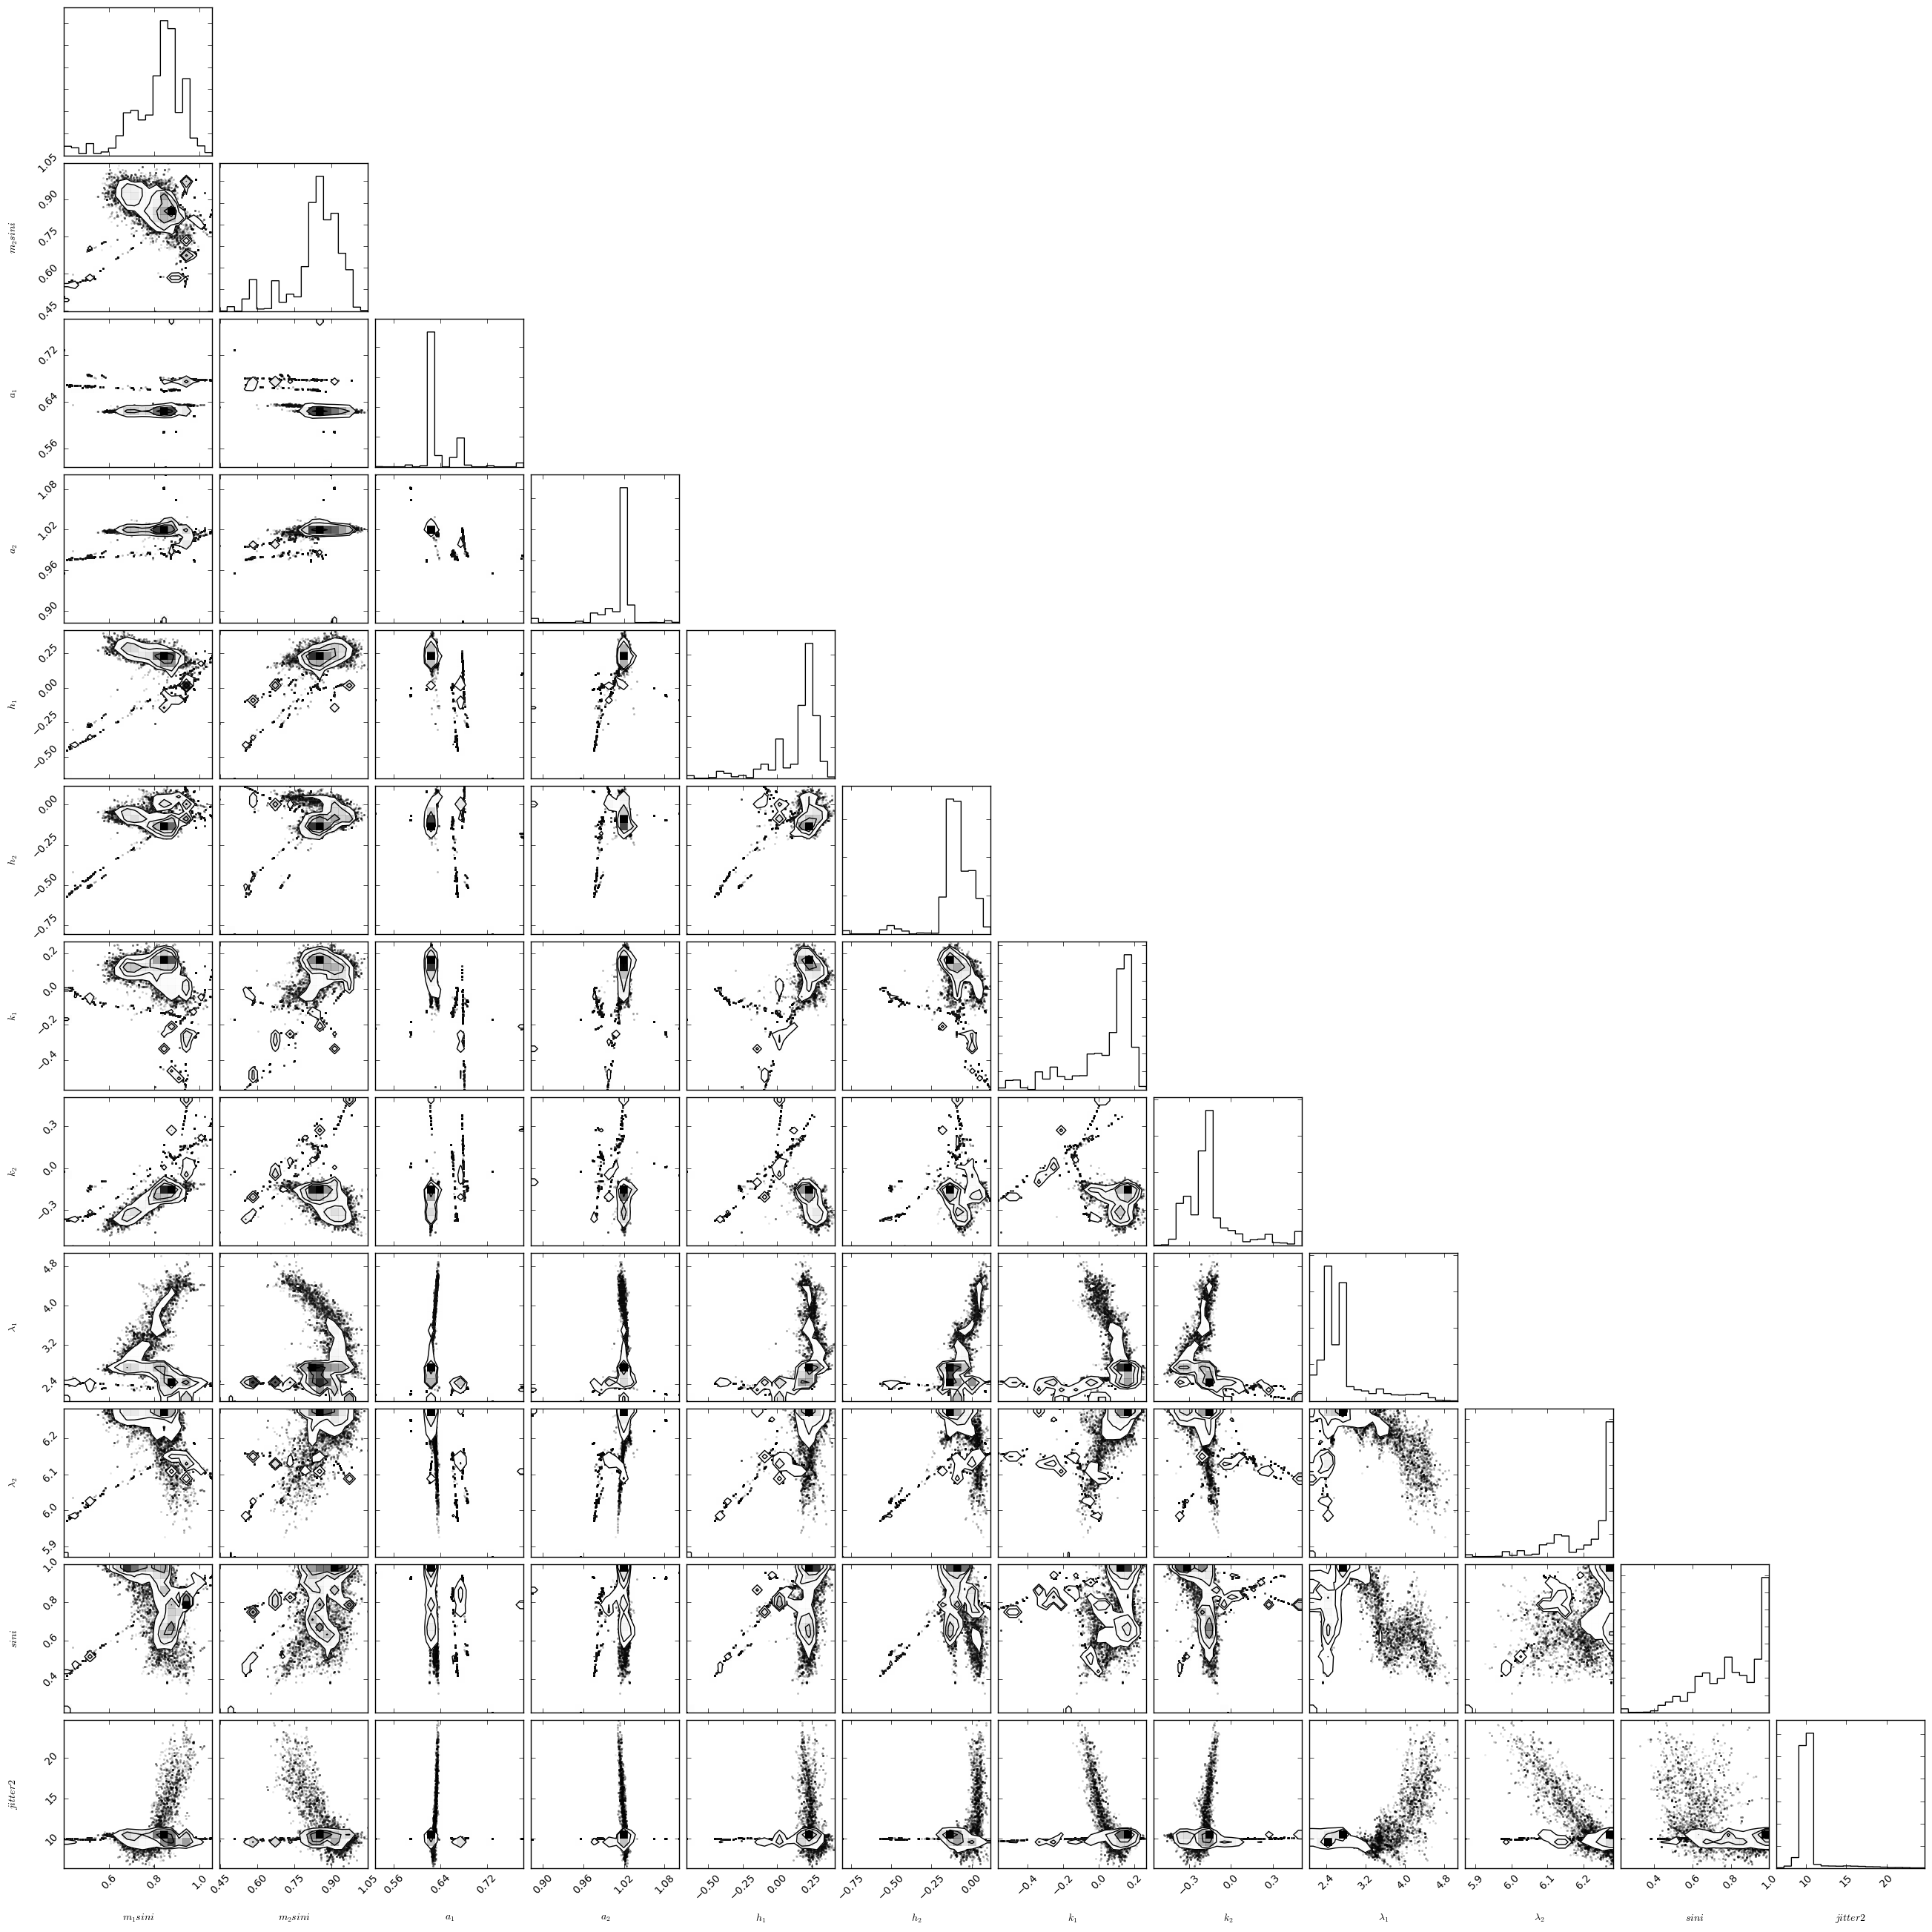

In [25]:
fig = corner.corner(samples, labels=["$m_1sini$","$m_2sini$","$a_1$","$a_2$","$h_1$","$h_2$","$k_1$","$k_2$","$\lambda_1$","$\lambda_2$","$sini$","$jitter2$"])
fig.savefig(filename+"_corner.png")

### Get/Plot MAP

In [ ]:
#Better way to do this? This result could depend on the binning. 
labels=["m1sini","m2sini","a1","a2","h1","h2","k1","k2","lambda1","lambda2","sini","jit2"]
MAP, std = [], []
for i in range(ndim):
    n, bins, patches = plt.hist(samples[:,i], 101, normed=1, facecolor='green', alpha=0.75);
    MAP.append(bins[np.argmax(n)])
    std.append(np.std(samples[:,i]))
plt.close()
p=zip(labels,MAP,std)
print "parameter \t MAP \t\t std"
for i in range(ndim):
    print "%s \t\t %f \t %f"%(p[i][0],p[i][1],p[i][2])

In [ ]:
#plotting stuff
from matplotlib import gridspec
fontsize=13
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1])]
plt.subplots_adjust(hspace = 0)
axes[0].set_ylabel("RV (m/s)",fontsize=fontsize)
axes[1].set_ylabel("MAP Residuals (m/s)",fontsize=fontsize)
axes[1].set_xlabel("BJD - 2450000",fontsize=fontsize)

#samples from posterior
t0 = data["BJD"].iloc[0]
tt = np.linspace(t0,max(data["BJD"]),300)
for theta in samples[np.random.randint(len(samples), size=100)]:
    sampleRV = fit_RV(tt-t0,theta[:-1])
    axes[0].plot(tt,sampleRV,color="k", alpha=0.1)
axes[0].plot(tt,sampleRV,color="k", label='posterior samples')

#MAP
RV = fit_RV(tt-t0,MAP[:-1])
Residuals = data["RV"] - fit_RV(data["BJD"] - data["BJD"].iloc[0],MAP[:-1])
axes[0].plot(tt,RV, color='green',linewidth=3, label='MAP')
axes[0].errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o', color='blue', label='data')
axes[1].plot(data["BJD"],Residuals, 'o', color='green')

#save
axes[0].legend(loc="upper left",fontsize=9,numpoints=1)
plt.savefig(filename+"_MAP_RV2.png")

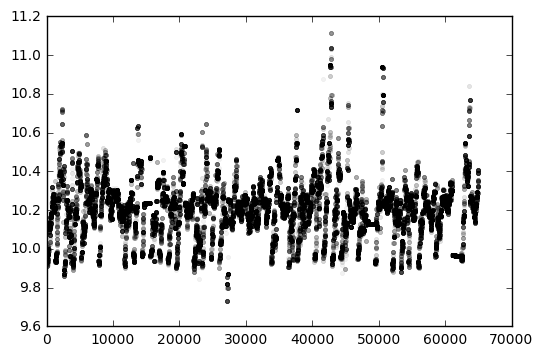

In [73]:
parameter = 11
plt.plot(samples[:,parameter], '.', alpha=0.05, color='black')

## Determine if system is in resonance.

In [20]:
def res_arg(sim):
    o1 = sim.particles[1].calculate_orbit(sim.particles[0])
    o2 = sim.particles[2].calculate_orbit(sim.particles[0])
    phi = 2.*o2.l - o1.l - o1.pomega
    phi2 = 2.*o2.l - o1.l - o2.pomega
    phi3 = o1.pomega - o2.pomega
    while(phi >= 2*np.pi):
        phi -= 2*np.pi
    while(phi < 0.):
        phi += 2*np.pi
    while(phi2 >= 2*np.pi):
        phi2 -= 2*np.pi
    while(phi2 < 0.):
        phi2 += 2*np.pi
    while(phi3 >= 2*np.pi):
        phi3 -= 2*np.pi
    while(phi3 < 0.):
        phi3 += 2*np.pi
    return phi, phi2, phi3

def check_resonance(theta,tmax,Npts):
    #m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    phi, phi2, phi3 = [], [], []
    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* a1**(1.5) / 50.    #dt = 50 steps per orb per of inner planet
    #sim.add(m=m1sini*mJ/sini,a=a1,l=lambda1,h=h1,k=k1) 
    #sim.add(m=m2sini*mJ/sini,a=a2,l=lambda2,h=h2,k=k2) 
    sim.add(m=m1sini*mJ/sini,a=a1,e=e1,omega=w1,M=M1) 
    sim.add(m=m2sini*mJ/sini,a=a2,e=e2,omega=w2,M=M2)  
    sim.move_to_com()
    for t in np.linspace(0,tmax,Npts):
        sim.integrate(t)
        p1,p2,p3 = res_arg(sim)
        phi.append(p1), phi2.append(p2), phi3.append(p3)
    return phi, phi2, phi3

In [21]:
burnin = 500
#filename="emcee_chains/ewfit_nojitter_50walk_1500step"
#filename="emcee_chains/ewfit_jitter_nopool_nwalk50_nit1500"
filename="emcee_chains/ewfit_jitter_50walk_5000it"
samples = np.load(filename+".npy")[:, burnin:, :].reshape((-1, ndim))

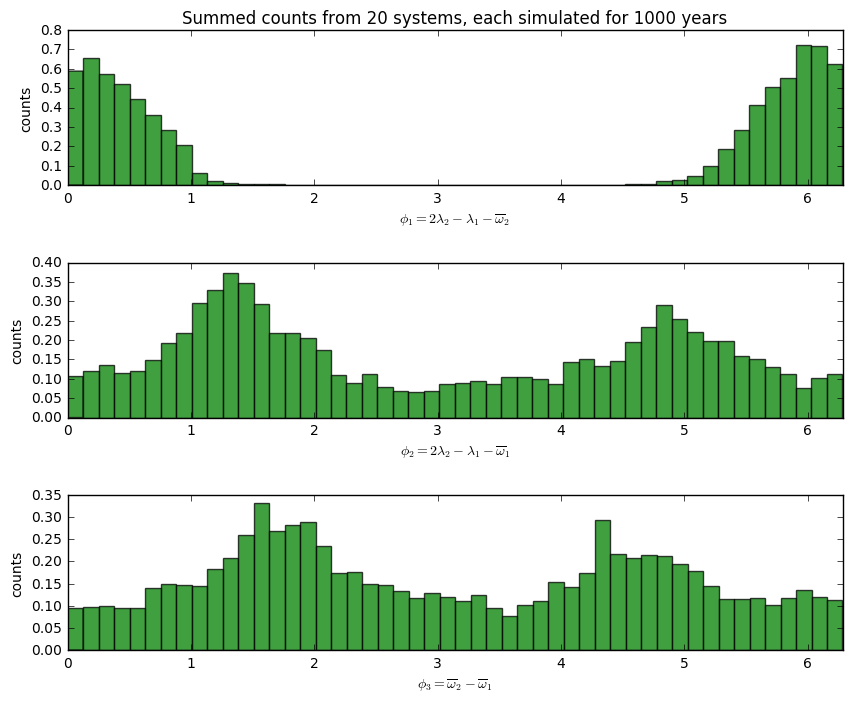

In [44]:
from matplotlib import gridspec
fontsize=13

#draw samples and see if system is in resonance
tmax = 1000
Npts = 500
Ndraws = 20
phi = []
phi2 = []
phi3 = []
for theta in samples[np.random.randint(len(samples), size=Ndraws)]:
    p1, p2, p3 = check_resonance(theta[:-1],tmax,Npts)
    phi = phi + p1
    phi2 = phi2 + p2
    phi3 = phi3 + p3

#plot
bins = 50
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2])]
plt.subplots_adjust(hspace = 0.5)
axes[0].hist(phi, bins, normed=1, facecolor='green', alpha=0.75);
axes[1].hist(phi2, bins, normed=1, facecolor='green', alpha=0.75);
axes[2].hist(phi3, bins, normed=1, facecolor='green', alpha=0.75);
axes[0].set_xlabel(r'$\phi_1 = 2\lambda_2 - \lambda_1 - \overline{\omega}_2$')
axes[1].set_xlabel(r'$\phi_2 = 2\lambda_2 - \lambda_1 - \overline{\omega}_1$')
axes[2].set_xlabel(r'$\phi_3 = \overline{\omega}_2 - \overline{\omega}_1$')
axes[0].set_title('Summed counts from %d systems, each simulated for %d years'%(Ndraws,tmax))
axes[0].set_ylabel('counts')
axes[1].set_ylabel('counts')
axes[2].set_ylabel('counts')
axes[0].set_xlim([0,2*np.pi])
axes[1].set_xlim([0,2*np.pi])
axes[2].set_xlim([0,2*np.pi])
plt.savefig(filename+'_rescheck.png')